C:\Users\Kamlesh P Panchal\AppData\Local\Temp\ipykernel_2848\3063733216.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map

Label(value='📂 Upload Image from Phone / PC')

FileUpload(value=(), accept='image/*', description='Upload')

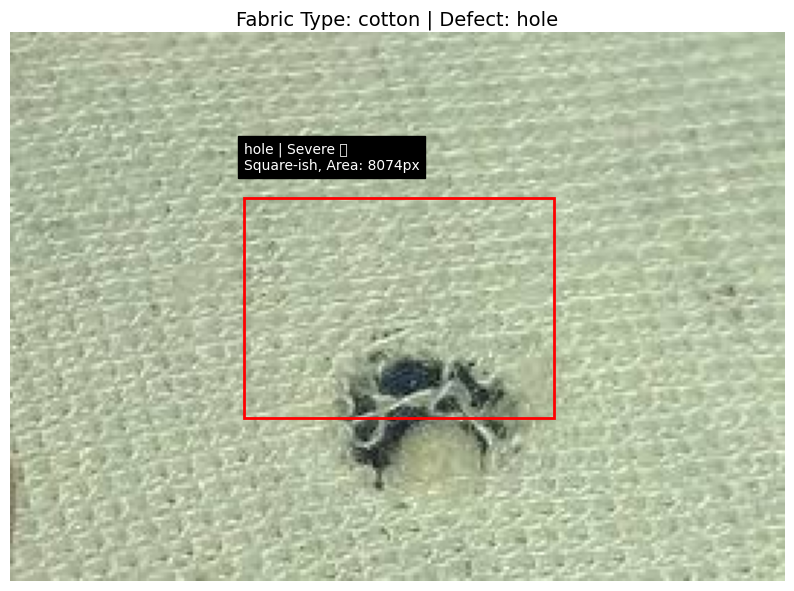

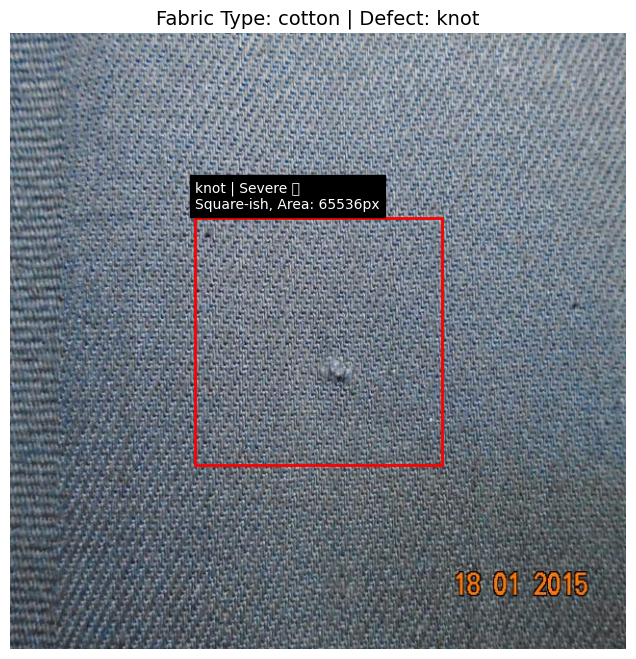

In [1]:
# SECTION 1: Imports and Setup

import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torchvision import transforms, models
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

from pathlib import Path
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
from io import BytesIO

# SECTION 2: Config & Class Names

# Paths
MODEL_PATH = r"models\combined_fabric_defect_model.pt"
CSV_PATH = r"fabric_dataset\fabric_types.csv"

# Labels
CLASSES = ['hole', 'knot', 'stain']
fabric_df = pd.read_csv(CSV_PATH)
unique_fabrics = sorted(fabric_df["Fabric_Type"].unique())
fabric_to_id = {name: i for i, name in enumerate(unique_fabrics)}
id_to_fabric = {v: k for k, v in fabric_to_id.items()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SECTION 3: Model

class CombinedClassifier(nn.Module):
    def __init__(self, num_defect_classes, num_fabric_classes):
        super().__init__()
        base = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(base.children())[:-1])
        feat_dim = base.fc.in_features

        self.defect_head = nn.Sequential(
            nn.Linear(feat_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_defect_classes)
        )
        self.fabric_head = nn.Sequential(
            nn.Linear(feat_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_fabric_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.defect_head(x), self.fabric_head(x)

# Load model
model = CombinedClassifier(len(CLASSES), len(fabric_to_id))
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device).eval()

# SECTION 4: Utilities

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

def compute_shape_descriptors(x1, y1, x2, y2, image_w, image_h):
    w, h = x2 - x1, y2 - y1
    area = w * h
    rel_area = area / (image_w * image_h)
    aspect_ratio = w / h if h != 0 else 0
    shape = "Tall & Narrow" if aspect_ratio < 0.5 else "Wide & Short" if aspect_ratio > 2 else "Square-ish"
    return area, rel_area, shape

def estimate_severity(rel_area):
    if rel_area < 0.01:
        return 'Minor', '🟢'
    elif rel_area < 0.03:
        return 'Moderate', '🟡'
    else:
        return 'Severe', '🔴'

# SECTION 5: Inference + Display

def predict_and_display(img_np):
    img_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    input_tensor = transform(img_rgb).unsqueeze(0).to(device)

    with torch.no_grad():
        defect_logits, fabric_logits = model(input_tensor)
        _, pred_defect = torch.max(defect_logits, 1)
        _, pred_fabric = torch.max(fabric_logits, 1)

    pred_defect_name = CLASSES[pred_defect.item()]
    pred_fabric_name = id_to_fabric[pred_fabric.item()]

    # Simulated "detection" — just draw one center box
    h, w = img_np.shape[:2]
    x1, y1, x2, y2 = w * 0.3, h * 0.3, w * 0.7, h * 0.7

    area, rel_area, shape = compute_shape_descriptors(x1, y1, x2, y2, w, h)
    severity, emoji = estimate_severity(rel_area)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(img_rgb)
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    label = f"{pred_defect_name} | {severity} {emoji}\n{shape}, Area: {area:.0f}px"
    ax.text(x1, y1 - 10, label, fontsize=10, color='white', backgroundcolor='black')

    plt.title(f"Fabric Type: {pred_fabric_name} | Defect: {pred_defect_name}", fontsize=14)
    plt.axis("off")
    plt.show()

# SECTION 6: Upload or Webcam Input

def on_image_upload(change):
    img_data = change['new'][0]['content']
    img_np = np.array(Image.open(BytesIO(img_data)).convert("RGB"))
    img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    predict_and_display(img_cv)

upload_widget = widgets.FileUpload(
    accept='image/*',
    multiple=False
)
upload_widget.observe(on_image_upload, names='value')
display(widgets.Label("📂 Upload Image from Phone / PC"))
display(upload_widget)

# SECTION 7 (FIXED): Webcam inside Jupyter

from IPython.display import clear_output
import time

def run_webcam():
    cap = cv2.VideoCapture(0)
    print("📸 Capturing from webcam. Press Capture to take a snapshot.")
    
    capture_button = widgets.Button(description="📸 Capture Snapshot", button_style='success')
    output = widgets.Output()

    def on_click(b):
        ret, frame = cap.read()
        cap.release()
        clear_output()
        predict_and_display(frame)

    capture_button.on_click(on_click)
    display(capture_button)
    display(output)

    # Show live preview (optional: we can remove this if CPU is slow)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img)
        with output:
            clear_output(wait=True)
            display(img_pil)
        time.sleep(0.1)

#run_webcam()

